In [6]:
import cProfile
import os
import statistics as st
import plotly.graph_objects as go
import random as rd
import time
import pandas as pd
import math
from collections import defaultdict
import numpy as np
import itertools as it
import Utilities.experiment_utils as eu
import unit_test as ut
import Games.mnk as mnk
import Games.Carcassonne.Carcassonne as carc
import Games.carcassonne_oldtry as csn_old
#import Games.carcassonne_older as csn
import Agents.random as arand
import Agents.vanilla_mcts as mcts
import Agents.siea_mcts as siea_mcts
import Agents.mcts_rave as rave_mcts
import Agents.one_step_lookahead as osla
import Agents.mcts_solver as mcts_solver
import Games.function_optimisation as fo
import Utilities.logs_management as lm
import Games.chess_64 as chess_64
import chess as chess
import chess.svg
import matplotlib.pyplot as plt
import shutil
import itertools
from IPython.display import display
import ast
from IPython.display import Image
import datetime
import multiprocessing as mp
from plotly.subplots import make_subplots

#cProfile.run("wins =  random_games(10000, base_gs)")
#ut.run()

import scipy.stats

def t(alpha, gl):
    return scipy.stats.t.ppf(1-(alpha/2), gl)
#https://stackoverflow.com/questions/67340028/how-to-use-t-ppf-which-are-the-arguments
#https://stackoverflow.com/questions/40294844/calculate-t-student-test-for-the-next-table-in-python
#https://www.geeksforgeeks.org/python-students-t-distribution-in-statistics/
#https://itl.nist.gov/div898/handbook/eda/section3/eda352.htm
#https://docs.tibco.com/data-science/GUID-8E64444A-5F5B-49F9-A43A-74B13647AFB4.html#:~:text=The%20larger%20the%20variation%2C%20the%20less%20reliable%20the,sample%20size%20is%20large%2C%20say%20n%3D100%20or%20more.

In [8]:
#recollect carc logs
#especific_experiment_path = "Carcassonne_less_tiles_det"
#especific_experiment_path = "Carcassonne_full_det_1p"
especific_experiment_path = "Carcassonne_full_sto_1p"
#find all paths in path = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det"
paths = os.listdir(os.path.join("Outputs","Carcassonne_1p",especific_experiment_path))
#remove path with DS_Store
paths = [path for path in paths if path != ".DS_Store"]
#print(paths)
for exp_path in paths:

    #Initialize final dataframes
    final_df_names = ["logs_by_game.csv", "logs_by_action.csv", "logs_by_iteration.csv"]
    final_dfs = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

    path_outside = os.path.join("Outputs","Carcassonne_1p",especific_experiment_path,exp_path)
    print("In path: ", path_outside)
    for game_number in range(1,21):

        #Read game data
        path = os.path.join(path_outside,"Game_"+str(game_number))
        by_dfs = [lm.read_csv(os.path.join(path,logs_name)) for logs_name in final_df_names]

        #Crate complementary data df
        complementary_data_df = lm.read_csv(os.path.join(path,"game_definition_data.csv"))
        assert len(complementary_data_df) == 1
        complementary_data_df["game_number"] = [game_number]

        #Add complementary data to each dataframe
        for df_index, df in enumerate(by_dfs):
            complementary_data_df_extended = pd.concat([complementary_data_df] * len(df), ignore_index=True)
            df = pd.concat([df, complementary_data_df_extended], axis=1)

            final_dfs[df_index] = pd.concat([final_dfs[df_index], df], ignore_index=True)

    #Add parameters data
    parameters = pd.read_csv(os.path.join(path_outside,"parameters.csv"))
    assert len(parameters) == 1
    for df in final_dfs:
        parameters_extended = pd.concat([parameters] * len(df), ignore_index=True)
        df = pd.concat([df, parameters], axis=1)
    
    #save data to dataframe
    for df_index, file_name in enumerate(final_df_names):
        lm.dump_data(data = final_dfs[df_index], file_path = path_outside, file_name = file_name)

In path:  Outputs/Carcassonne_1p/Carcassonne_full_sto_1p/20231024_124157_1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DtypeWarning: Columns (31,37,764,765,766,770,771,772,776,777,778,782,783,784,788,789,790,794,795,796,800,801,802,806,807,808,812,813,814,818,819,820,824,825,826,830,831,832,836,837,838,842,843,844,848,849,850,854,855,856,860,861,862,866,867,868,872,873,874,878,879,880,884,885,886,890,891,892,896,897,898,902,903,904,908,909,910,914,915,916,920,921,922,926,927,928,932,933,934,938,939,940,944,945,946,950,951,952,956,957,958,962,963,964,968,969,970,974,975,976,980,981,982,986,987,988,992,993,994,998,999,1000,1004,1005,1006,1010,1011,1012,1016,1017,1018,1022,1023,1024,1028,1029,1030,1034,1035,1036,1040,1041,1042,1046,1047,1048,1052,1053,1054,1058,1059,1060,1064,1065,1066,1070,1071,1072,1076,1077,1078,1082,1083,1084,1088,1089,1090,1094,1095,1096,1100,1101,1102,1106,1107,1108,1112,1113,1114,1118,1119,1120,1124,1125,1126,1130,1131,1132,1136,1137,1138,1142,1143,1144,1148,1149,1150,1154,1155,1156,1160,1161,1162,1166,1167,1168,1172,

In path:  Outputs/Carcassonne_1p/Carcassonne_full_sto_1p/20231024_124157_2


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DtypeWarning: Columns (386,387,388,392,393,394,398,399,400,404,405,406,410,411,412,416,417,418,422,423,424,428,429,430,434,435,436,440,441,442,446,447,448,452,453,454,458,459,460,464,465,466,470,471,472,476,477,478,482,483,484,488,489,490,494,495,496,500,501,502,506,507,508,512,513,514,518,519,520,524,525,526,530,531,532,536,537,538,542,543,544,548,549,550,554,555,556,560,561,562,566,567,568,572,573,574,578,579,580,584,585,586,590,591,592,596,597,598,602,603,604,608,609,610,614,615,616,620,621,622,626,627,628,632,633,634,638,639,640,644,645,646,650,651,652,656,657,658,662,663,664,668,669,670,674,675,676,680,681,682,686,687,688,692,693,694,698,699,700,704,705,706,710,711,712,716,717,718,722,723,724,728,729,730,734,735,736,740,741,742,746,747,748,752,753,754,758,759,760,764,765,766,770,771,772,776,777,778,782,783,784,788,789,790,794,795,796,800,801,802,806,807,808,812,813,814,818,819,820,824,825,826,830,831,832,836,837,838,

In path:  Outputs/Carcassonne_1p/Carcassonne_full_sto_1p/20231024_124157_3


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DtypeWarning: Columns (37,43,49,55,61,67,73,79,85,117,123,129,135,141,476,477,478,482,483,484,488,489,490,494,495,496,500,501,502,506,507,508,512,513,514,518,519,520,524,525,526,530,531,532,536,537,538,542,543,544,548,549,550,554,555,556,560,561,562,566,567,568,572,573,574,578,579,580,584,585,586,590,591,592,596,597,598,602,603,604,608,609,610,614,615,616,620,621,622,626,627,628,632,633,634,638,639,640,644,645,646,650,651,652,656,657,658,662,663,664,668,669,670,674,675,676,680,681,682,686,687,688,692,693,694,698,699,700,704,705,706,710,711,712,716,717,718,722,723,724,728,729,730,734,735,736,740,741,742,746,747,748,752,753,754,758,759,760,764,765,766,770,771,772,776,777,778,782,783,784,788,789,790,794,795,796,800,801,802,806,807,808,812,813,814,818,819,820,824,825,826,830,831,832,836,837,838,842,843,844,848,849,850,854,855,856,860,861,862,866,867,868,872,873,874,878,879,880,884,885,886,890,891,892,896,897,898,902,903,904,9

In [ ]:
#Load and preprocess outputs
#especific_experiment_path = "Carcassonne_less_tiles_det"
especific_experiment_path = "Carcassonne_full_sto_1p"

#experiment_path = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det")
experiment_path = os.path.join("Outputs","Carcassonne_1p",especific_experiment_path)
logs_names = ["logs_by_game.csv", "logs_by_action.csv", "logs_by_iteration.csv"]

outputs_paths = os.listdir(experiment_path)
logs_list = {log_name:pd.DataFrame() for log_name in logs_names}
outputs_paths = [path for path in outputs_paths if path != ".DS_Store" and ".csv" not in path]

for path in outputs_paths:
    for log_name in logs_names:
        logs_list[log_name] = pd.concat([logs_list[log_name], lm.read_csv(os.path.join(experiment_path, path, log_name))], ignore_index=True)

#preprocessing

for log_name, logs in logs_list.items():
    for column_to_int in ["pg_game_turn", "game_index", "pg_player_index"]:
        if column_to_int not in logs.columns:
            continue
        if type(logs[column_to_int].iloc[0]) is str:
            assert logs[column_to_int].iloc[0][0] == "[" and logs[column_to_int].iloc[0][-1] == "]"
            logs[column_to_int] = logs[column_to_int].apply(lambda x: int(x[1:-1]))
    temp_col = "initial_meeples"
    if temp_col in logs.columns:
        logs[temp_col] = logs[temp_col].apply(lambda x: int(x[1:-1].split(",")[0]))


for i in [1,2]: #dependencie alert: names of the columns in the logs
    print("Processing meeple info from: ", logs_names[i])
    meeple_types = ["Meeple", "City", "Road", "Cloister", "Farm", "Non-Meeple"]
    info_to_track = ["_all_rewards", "_all_visits", "_average_rewards", "_std_rewards", "_average_visits", "_std_visits","_max_reward", "_min_reward", "_max_visit", "_min_visit", "_alternatives_count"]
    new_data = {mt + itt : [] for mt in meeple_types for itt in info_to_track}

    for row_idx, row in logs_list[logs_names[i]].iterrows():
        names = {meeple_type:[] for meeple_type in meeple_types}

        #iterate through columns
        for column_name in row.index:
            if "action" in column_name: #dependencie
                split_name = column_name.split("_")
                if len(split_name) == 1:
                    #print("found action column", column_name, row[column_name])
                    #if type(row[column_name]) is not str: print("non string argument: ", row[column_name])
                    if "Meeple Location" in str(row[column_name]): #dependencie
                        print("found action column", column_name)
                        names["Meeple"].append(column_name)
                        if "Farm" in row[column_name]:
                            names["Farm"].append(column_name)
                        elif "City" in row[column_name]:
                            names["City"].append(column_name)
                        elif "Road" in row[column_name]:
                            names["Road"].append(column_name)
                        elif "Cloister" in row[column_name]:
                            names["Cloister"].append(column_name)
                    else:
                        names["Non-Meeple"].append(column_name)

        for meeple_type, columns in names.items():
            all_rewards = []
            all_visits = []
            for column in columns:
                all_rewards.append(row[column + "_avg_reward"])
                all_visits.append(row[column + "_visits"])
            new_data[meeple_type + "_all_rewards"].append(str(all_rewards))
            new_data[meeple_type + "_all_visits"].append(str(all_visits))
            new_data[meeple_type + "_average_rewards"].append(st.mean(all_rewards)) if len(all_rewards) > 0 else new_data[meeple_type + "_average_rewards"].append(None)
            new_data[meeple_type + "_std_rewards"].append(st.stdev(all_rewards)) if len(all_rewards) > 1 else new_data[meeple_type + "_std_rewards"].append(None)
            new_data[meeple_type + "_average_visits"].append(st.mean(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_average_visits"].append(None)
            new_data[meeple_type + "_std_visits"].append(st.stdev(all_visits)) if len(all_visits) > 1 else new_data[meeple_type + "_std_visits"].append(None)
            new_data[meeple_type + "_max_reward"].append(max(all_rewards)) if len(all_rewards) > 0 else new_data[meeple_type + "_max_reward"].append(None)
            new_data[meeple_type + "_min_reward"].append(min(all_rewards)) if len(all_rewards) > 0 else new_data[meeple_type + "_min_reward"].append(None)
            new_data[meeple_type + "_max_visit"].append(max(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_max_visit"].append(None)
            new_data[meeple_type + "_min_visit"].append(min(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_min_visit"].append(None)
            new_data[meeple_type + "_alternatives_count"].append(len(columns))

    new_df = pd.DataFrame(new_data)
    assert len(new_df) == len(logs_list[logs_names[i]])
    logs_list[logs_names[i]] = pd.concat([logs_list[logs_names[i]], new_df], axis=1) 

#save processed data
for log_name, logs in logs_list.items():
    lm.dump_data(data = logs, file_path = experiment_path, file_name = log_name)

In [24]:
logs_list[logs_names[1]][["action0", "action1","Meeple_all_rewards", "Non-Meeple_all_rewards", "Meeple_all_visits", "Non-Meeple_all_visits"]]

,action0,action1,Meeple_all_rewards,Non-Meeple_all_rewards,Meeple_all_visits,Non-Meeple_all_visits
0,"TileIndex: 4, (X,Y): (-1,0), Rotation: 270, Me...","TileIndex: 4, (X,Y): (1,0), Rotation: 90, Meep...","[0.0067984338458476, 0.005570652173913, 0.0132...","[0.0138121940972646, 0.0127328976640711, 0.014...","[169, 166.0, 191.0, 160.0, 169.0, 158.0, 195.0...","[193.0, 189.0, 195.0, 195.0, 190.0, nan, nan, ..."
1,"TileIndex: 18, (X,Y): (-1,1), Rotation: 0","TileIndex: 18, (X,Y): (-1,1), Rotation: 180",[],"[0.0305148613716886, 0.0279590577468476, 0.028...",[],"[452, 421.0, 431.0, 475.0, 489.0, 446.0, 409.0..."
2,"TileIndex: 22, (X,Y): (2,1), Rotation: 0","TileIndex: 22, (X,Y): (-1,0), Rotation: 0",[],"[0.0367015137701996, 0.0354611987817841, 0.035...",[],"[1097, 1038.0, 1063.0, 975.0, 827.0, nan, nan,..."
3,"TileIndex: 14, (X,Y): (0,-1), Rotation: 270","TileIndex: 14, (X,Y): (1,2), Rotation: 270",[],"[0.0365656043694671, 0.0317906433839646, 0.024...",[],"[385, 340.0, 285.0, 403.0, 350.0, 375.0, 367.0..."
4,"TileIndex: 5, (X,Y): (2,0), Rotation: 90, Meep...","TileIndex: 5, (X,Y): (-1,2), Rotation: 270, Me...","[0.0649261649236589, 0.0668997996905726, 0.046...","[0.0552414468040931, 0.0559508020714917, 0.055...","[246, 257.0, 172.0, 210.0, 211.0, 253.0, 222.0...","[202.0, 205.0, 202.0, 202.0, 211.0, 212.0, 199..."
...,...,...,...,...,...,...
4255,"TileIndex: 18, (X,Y): (-7,3), Rotation: 90","TileIndex: 18, (X,Y): (2,5), Rotation: 180",[],"[0.5523759127808092, 0.5387727740668922, 0.539...",[],"[113, 93.0, 95.0, 95.0, 94.0, 100.0, 99.0, 98...."
4256,"TileIndex: 20, (X,Y): (-7,0), Rotation: 0","TileIndex: 20, (X,Y): (4,3), Rotation: 0",[],"[0.5527428044639761, 0.5526255974343421, 0.552...",[],"[264, 263.0, 263.0, 263.0, 262.0, 263.0, 265.0..."
4257,"TileIndex: 13, (X,Y): (4,-4), Rotation: 270","TileIndex: 13, (X,Y): (3,7), Rotation: 0",[],"[0.5518793480421387, 0.5521564074195653, 0.551...",[],"[93, 94.0, 93.0, 99.0, 94.0, 93.0, 93.0, 93.0,..."
4258,"TileIndex: 20, (X,Y): (-4,-1), Rotation: 0","TileIndex: 20, (X,Y): (-3,7), Rotation: 0",[],"[0.564523439523442, 0.5645087907445345, 0.5645...",[],"[264, 263.0, 263.0, 264.0, 263.0, 263.0, 263.0..."


In [63]:
#grouped = logs_list[1].groupby(["pg_game_turn"]).mean().reset_index()
#Plotly box plot
#fig = go.Figure()
#fig.add_trace(go.Box(x=logs_list[logs_names[1]]["pg_game_turn"],y=logs_list[logs_names[1]]["Score_p1"], name="Score_p1"))

#define variables
to_show = "Average" #Average or Boxplot
logs_index = 1
plot_separation_column = "initial_meeples"
box_group_column = "player_name"
x_column = "pg_game_turn"
y_column = "Score_p1"
#y_column = "avg_leaf_node_depth"
#y_column = "Meeples_p1"


#Calculate uniques
plot_identifiers = logs_list[logs_names[logs_index]][plot_separation_column].unique()
box_group_identifiers = logs_list[logs_names[logs_index]][box_group_column].unique()
colors = ["#5B8C5A","#56638A", "#EC7316"]
print("plot_identifiers", plot_identifiers)
print("box_group_identifiers", box_group_identifiers)

#Create figure
fig = make_subplots(rows=len(plot_identifiers)
                        ,cols=1
                        ,shared_xaxes=True
                        ,vertical_spacing=0.04
                        ,row_heights=[1/len(plot_identifiers) for _ in range(len(plot_identifiers))]
                        ,subplot_titles = [str(i) + " starting meeples" for i in plot_identifiers]
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Turn"
                        ,y_title='Score'
                        #,print_grid=True
                        )

for row, plot_identifier in enumerate(plot_identifiers):
    for group_id, box_group_identifier in enumerate(box_group_identifiers):
        data = logs_list[logs_names[logs_index]][logs_list[logs_names[logs_index]][plot_separation_column] == plot_identifier]
        data = data[data[box_group_column] == box_group_identifier]
        if to_show == "Average":
            x = list(data[x_column].unique())
            y1 = []
            y1_lower = []
            y1_upper = []
            for x_unique in x:
                temp_data = data[data[x_column] == x_unique]
                values = temp_data[y_column]
                current_mean = st.mean(values)
                y1.append(current_mean)
                std = st.stdev(values)
                #y_lower.append()
                y1_lower.append(current_mean - std / math.sqrt(len(values)))
                y1_upper.append(current_mean + std / math.sqrt(len(values)))
                #print(y1_lower[-1], y1[-1], y1_upper[-1])

            #Prepare data for plot
            x_rev = x[::-1]
            y1_lower = y1_lower[::-1]

            #Plot
            shadow_color = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(colors[group_id]), 0.3))
            fig.add_trace(go.Scatter(
                    x=x+x_rev
                    ,y=y1_upper+y1_lower
                    ,fill='toself'
                    ,fillcolor=colors[group_id]
                    ,line_color=colors[group_id]
                    ,showlegend=False
                    ,opacity = 0.5
                    #,marker={"color":colors[group_id]}
                    )
                ,row=plot_identifier
                ,col=1)
            
            fig.add_trace(go.Scatter(
                    x=x
                    ,y=y1
                    ,line_color=colors[group_id]
                    ,name=str(box_group_identifier)
                    ,showlegend=row==1
                    ,legendgroup=str(box_group_identifier)
                    )
                ,row=plot_identifier
                ,col=1)
            

        elif to_show == "Boxplot":
            fig.add_trace(go.Box(x=data[x_column]
                                ,y=data[y_column]
                                ,name=str(box_group_identifier)
                                #, width=0.2
                                ,showlegend=row==1
                                ,legendgroup=str(box_group_identifier)
                                , marker={"color":colors[group_id]}
                                )
                            ,row=plot_identifier
                            ,col=1)

fig.update_layout(margin=dict(l=70, r=10, t=30, b=50)
                        ,width=1200
                        ,height=700
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        #,boxmode='group'
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,legend=dict(
                            title = "Scores by MCTS variant"
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.075
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            ) 
                        )
if to_show == "Average":
    fig.update_traces(mode='lines')
elif to_show == "Boxplot":
    fig.update_layout(boxmode='group')
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    #,tick0 = 0
                    , gridcolor="#5B8C5A"
                    , gridwidth=0.1
                    #, dtick=5000
                    ,showgrid=True
                    )
fig.show()

plot_identifiers [1 2 3]
box_group_identifiers ['MCTS_c0.5' 'MCTS_c3']


In [56]:
import plotly.graph_objects as go
import numpy as np



x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_rev = x[::-1]

# Line 1
y1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1_upper = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y1_lower = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y1_lower = y1_lower[::-1]

fig = go.Figure()

print(x+x_rev)
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    name='Fair',
))

fig.update_traces(mode='lines')
fig.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [13]:
import plotly.graph_objects as go
import numpy as np

# Example list of values
values = np.random.normal(loc=0, scale=1, size=100)  # Generate some random data

# Calculate statistics
mean_value = np.mean(values)

# Separate the dataset
values_below = values[values < mean_value]
values_above = values[values >= mean_value]

# Calculate the variance for the subsets
var_below_mean = np.var(values_below)
var_above_mean = np.var(values_above)

# Define the upper and lower bounds for the shaded area
lower_bound = mean_value - var_below_mean
upper_bound = mean_value + var_above_mean

# Define x-axis range
x = np.arange(0, len(values))

# Create traces
mean_line = go.Scatter(
    x=x,
    y=[mean_value] * len(x),
    mode='lines',
    name='Mean'
)

shaded_area = go.Scatter(
    x=np.concatenate([x, x[::-1]]),  # x, then x reversed
    y=np.concatenate([upper_bound, lower_bound[::-1]]),  # upper, then lower reversed
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
)

# Create a figure
fig = go.Figure()

# Add traces
fig.add_trace(shaded_area)
fig.add_trace(mean_line)

# Update layout
fig.update_layout(
    title="Mean with Variance Area",
    xaxis_title="Index",
    yaxis_title="Value",
    hovermode="closest"
)

# Show plot
fig.show()




IndexError: invalid index to scalar variable.

In [15]:
import plotly.graph_objects as go
import numpy as np

# Sample data
group1 = np.random.normal(loc=0, scale=1, size=100)
group2 = np.random.normal(loc=0, scale=1, size=100)
group3 = np.random.normal(loc=0, scale=1, size=100)
group4 = np.random.normal(loc=0, scale=1, size=100)

# X values for the box plots
x_values_group1 = ['Group 1'] * len(group1)
x_values_group2 = ['Group 2'] * len(group2)
x_values_group3 = ['Group 3'] * len(group3)
x_values_group4 = ['Group 4'] * len(group4)

# Create a figure
fig = go.Figure()

# Add boxplots
fig.add_trace(go.Box(y=group1, x=x_values_group1, name='Group 1', marker_color='blue'))
fig.add_trace(go.Box(y=group2, x=x_values_group2, name='Group 2', marker_color='orange'))
# Manually adjust x values for the third group to create a custom gap
fig.add_trace(go.Box(y=group3, x=[val + " " for val in x_values_group3], name='Group 3', marker_color='green'))
fig.add_trace(go.Box(y=group4, x=x_values_group4, name='Group 4', marker_color='red'))

# Update layout if needed
fig.update_layout(
    title_text="Custom Gap Between Grouped Boxplot Example",
    boxmode='group' # group boxplots together by name
)

fig.show()



In [ ]:
#recollect carc logs

#find all paths in path = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det"
paths = os.listdir(os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det"))
#print(paths)
for exp_path in paths:

    #Initialize final dataframes
    final_df_names = ["logs_by_game.csv", "logs_by_action.csv", "logs_by_iteration.csv"]
    final_dfs = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

    path_outside = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det",exp_path)
    print("In path: ", path_outside)
    for game_number in range(1,21):

        #Read game data
        path = os.path.join(path_outside,"Game_"+str(game_number))
        by_dfs = [lm.read_csv(os.path.join(path,logs_name)) for logs_name in final_df_names]

        #Crate complementary data df
        complementary_data_df = lm.read_csv(os.path.join(path,"game_definition_data.csv"))
        assert len(complementary_data_df) == 1
        complementary_data_df["game_number"] = [game_number]

        #Add complementary data to each dataframe
        for df_index, df in enumerate(by_dfs):
            complementary_data_df_extended = pd.concat([complementary_data_df] * len(df), ignore_index=True)
            df = pd.concat([df, complementary_data_df_extended], axis=1)
            #check for duplicated colums
            #print("Printing duplicated columns within each df:")
            #print(df.columns[df.columns.duplicated()])
            #print(final_dfs[df_index].columns[final_dfs[df_index].columns.duplicated()])
            #print("Overlapping:", df.columns.intersection(final_dfs[df_index].columns))

            final_dfs[df_index] = pd.concat([final_dfs[df_index], df], ignore_index=True)

    #Add parameters data
    parameters = pd.read_csv(os.path.join(path_outside,"parameters.csv"))
    assert len(parameters) == 1
    for df in final_dfs:
        parameters_extended = pd.concat([parameters] * len(df), ignore_index=True)
        df = pd.concat([df, parameters], axis=1)
    
    #save data to dataframe
    for df_index, file_name in enumerate(final_df_names):
        lm.dump_data(data = final_dfs[df_index], file_path = path_outside, file_name = file_name)

    #break
#print(df_by_game["Score_p1"])
#print mean score
#print(pd.read_csv(os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det",exp_path,"parameters.csv")))
#print(df_by_game["Score_p1"].mean())
#print(df_by_game["game_time"].mean())
#print(df_by_game["Total_played_meeples_p1"].mean())

In [2]:
#game_state = mnk.GameState(3,3,3)
game_state = carc.CarcassonneState(set_tile_sequence=True, set_tile_sequence_seed=0, players = 1, initial_meeples=[1,1])
game_state.set_initial_state()
agent = mcts.MCTS_Player(max_iterations = 50, logs = True, logs_every_iterations=10)
gp = eu.GamePlayer(game_state, [agent])
gp.play_game(random_seed=0)
gp.save_data(file_path = os.path.join("Outputs", "test", "gp_iteration_logs"))
#action = agent.choose_action(game_state)
#agent.dump_my_logs(path = os.path.join("Outputs", "test", "new_iteration_logs"))

In [2]:
##Multiprocess experiment
datetime_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_path = os.path.join("Outputs","Carcassonne_1p", datetime_string)

class ExperimentParser():
    def __init__(self, seed, games, runs, iterations, c, meeples, rollouts, random_events, file_path):
        self.seed = seed
        self.games = games
        self.runs = runs
        self.iterations = iterations
        self.c = c
        self.meeples = meeples
        self.rollouts = rollouts
        self.random_events = random_events
        self.file_path = file_path

def run_experiment(parser):
#Declare parameters
    print("Experiment started with parameters:", parser.__dict__)

    #Store parser's parameters
    parser_df = pd.DataFrame(parser.__dict__, index=[0])
    lm.dump_data(file_path=parser.file_path, data=parser_df, file_name="parameters.csv")

    #Create game states
    game_state_seeds = [x for x in range(parser.games)]
    initial_game_states = [carc.CarcassonneState(name = "Carcassonne_1p_set",
                                                set_tile_sequence= parser.random_events == 0,
                                                set_tile_sequence_seed=game_seed,
                                                initial_meeples = [parser.meeples, parser.meeples],
                                                players = 1) for game_seed in game_state_seeds]
    for game_state in initial_game_states:
        game_state.set_initial_state()

    #Set seeds
    rd.seed(parser.seed)
    np.random.seed(parser.seed)

    #Create player
    players = [mcts.MCTS_Player(max_iterations =parser.iterations,
                                    c=parser.c,
                                    logs=True,
                                    logs_every_iterations = int(parser.iterations/10),
                                    name = "MCTS_c" + str(parser.c),
                                    rollouts=parser.rollouts)]

    #Create gameplayer

    for game_idx, game_state in enumerate(initial_game_states):
        print("Running game", str(game_idx+1), "of", str(parser.games))
        gameplayer = eu.GamePlayer(game_state, players)
        gameplayer.play_games(n_games=parser.runs, 
                            random_seed=parser.seed,
                            logs=True,
                            logs_path=os.path.join(parser.file_path, "Game_" + str(game_idx+1)))

    #gameplayer.save_data(file_path=file_path)

parser1 = ExperimentParser(seed=0, games=3, runs=1, iterations=500, c=0.5, meeples=1, rollouts=1, random_events=0, file_path=file_path + "_" + str(1))
parser2 = ExperimentParser(seed=0, games=3, runs=1, iterations=500, c=0.5, meeples=2, rollouts=1, random_events=0, file_path=file_path + "_" + str(2))
parser3 = ExperimentParser(seed=0, games=3, runs=1, iterations=500, c=0.5, meeples=3, rollouts=1, random_events=0, file_path=file_path + "_" + str(3))
parser4 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=3, meeples=1, rollouts=1, random_events=0, file_path=file_path + "_" + str(4))
parser5 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=3, meeples=2, rollouts=1, random_events=0, file_path=file_path + "_" + str(5))
parser6 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=3, meeples=3, rollouts=1, random_events=0, file_path=file_path + "_" + str(6))

arguments = [parser1, parser2]#, parser3, parser4, parser5, parser6]

import multiprocessing as mp
num_processes = 2#mp.cpu_count()-2  # Use as many processes as your CPU has cores
pool = mp.Pool(processes=num_processes)

# Map the function to the arguments using the process pool
pool.map(run_experiment, arguments)

# Close the pool and wait for the work to finish
pool.close()
pool.join()
#run_experiment(parser1)
#run_experiment(parser2)
#run_experiment(parser3)
#cProfile.run("run_experiment(parser1)")

In [ ]:
#One player test
game_state = carc.CarcassonneState(name = "Carcassonne_1p_set", set_tile_sequence=True, set_tile_sequence_seed=0, initial_meeples = [1], players = 1)
game_state.set_initial_state()
#players = [arand.RandomPlayer()]
players = [mcts.MCTS_Player(max_iterations =50)]
gameplayer = eu.GamePlayer(game_state, players)
gameplayer.play_game()
gameplayer.logs_by_game
#get detailed logs on first decision

In [6]:
gameplayer.save_data(file_path = os.path.join("Outputs","test","Carcassonne_1p_vanilla"))

In [ ]:
#Small carcassonne
games = 10
date_time_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
game_state = carc.CarcassonneState(set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[1,1])
game_state.set_initial_state()
agents = [mcts.MCTS_Player(max_iterations=5000, c=0.5, name="mcts_vanilla_c_05"), mcts.MCTS_Player(max_iterations=5000, c=3, name="mcts_vanilla_c_3")]
gp1, gp2 = eu.play_match(agents, game_state, games, os.path.join("Outputs", "Matches", "Carcassonne_fixed_sequence_" + date_time_string), random_seed = 0)
#cProfile.run("gp1, gp2 = eu.play_match(agents, game_state, 2, os.path.join('Outputs', 'Matches', 'Carcassonne_fixed_sequence_' + date_time_string), random_seed = 2)")

In [18]:
#View tree on each iteration - STEP 1

#parameters
game_idx = 8
agent_idx = 0
agent_rollouts = 1
#puzzle_idx = 66 #matein3
puzzle_idx = 62
#max_iterations = 0
max_iterations = 0
iterations_logs_step = 10

#database
games = ["chess", "ttt", "carcassonne", "carcassonne_1", "carcassonne_discard","chess_puzzle", "ttt_setup", "carcassonne_sequence", "carc_sequence_1p"]
game = games[game_idx]
print("Game:", game)
agent_types = ["mcts", "rave_mcts", "siea_mcts", "mcts_solver", "siea_mcts2"]
agent_type = agent_types[agent_idx]
print("Agent:", agent_type)

#agent definition
if agent_type == "mcts":
    mcts_agent = mcts.MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "rave_mcts":
    mcts_agent = rave_mcts.MCTS_RAVE(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "mcts_solver":
    mcts_agent = mcts_solver.MCTS_Solver(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts2":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(name = "siea_mcts2", max_iterations = max_iterations, rollouts=agent_rollouts, unpaired_evolution=True)

#game definition
if game == "chess":
    game_state = chess_64.GameState()
    game_state.set_initial_state()
elif game == "ttt":
    game_state = mnk.GameState(3,3,3)
    game_state.set_initial_state()
elif game == "ttt_setup":
    game_state = mnk.GameState(3,3,3)
    game_state.set_board(board_items = {(1,1):0, 
                                    (0,0):0, 
                                    (2,2):1, 
                                    (0,1):1,
                                    #(1,0):0
                                    }, player_turn = 0)
elif game == "carcassonne":
    game_state = carc.CarcassonneState()
    game_state.set_initial_state()
elif game == "carcassonne_1":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
    game_state.set_initial_state()
elif game == "carcassonne_discard":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
    game_state.set_initial_state()
elif game == "carcassonne_sequence":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)], set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[2,2])
    game_state.set_initial_state()
elif game == "carc_sequence_1p":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)], set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[2,2], players = 1)
    game_state.set_initial_state()
elif game == "chess_puzzle":
    game_state = chess_64.GameState()
    #Load lichess dataset
    lichess_db = pd.read_csv("Datasets/mates_processed_lichess_db_puzzle.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_db_puzzle_subsample.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_1000_most_played.csv")
    
    puzzle_row = lichess_db.iloc[puzzle_idx]
    game_state.set_puzzle_lichess_db(puzzle_row)
    print("Move to look for:", puzzle_row["Moves"].split(" ")[1])
    print("Moves to look for:", puzzle_row["Moves"])
    print(puzzle_row["Themes"])
    
#game_state.view_game_state()

#Initialize mcts agent
if max_iterations == 0:
    random_action = mcts_agent.choose_action(game_state)
    print("N available_moves:", len(game_state.available_actions))
    #print("Root node:", mcts_agent.view_mcts_tree())
    #game_state.view_game_state()
    print("Player:",mcts_agent.player)
else:
    mcts_agent.choose_action(game_state)
    print("Current decision node: ", mcts_agent.recommendation_policy())
    print("Iterations: ", mcts_agent.current_iterations)
    print("FM calls: ", mcts_agent.current_fm)
    #print(mcts_agent.view_mcts_tree())
    print(mcts_agent.view_action_stats())
    #print(mcts_agent.view_proven_tree())
    if "siea" in agent_type:
        print("Evolution fm calls: ", mcts_agent.evolution_fm_calls)
    print("Node count: ", mcts_agent.nodes_count)
#game_state.board
    

Game: carc_sequence_1p
Agent: mcts
N available_moves: 3
Player: 0


Iterations:  700
FM calls:  16100
Recommended action:  TileIndex: 20, (X,Y): (0,-1), Rotation: 0, Meeple Location: Monastery, Location Index: 0

0:Decision_node, edge:None, visits:700, avg_rwd:0.0767, children:3,from:3, tree_policy:None
--1:Decision_node, edge:TileIndex: 20, (X,Y): (0,-1), Rotation: 0, visits:198, avg_rwd:0.0545, children:16,from:16, tree_policy:0.312
----5:Decision_node, edge:TileIndex: 11, (X,Y): (0,1), Rotation: 0, Meeple Location: City, Location Index: 0, visits:13, avg_rwd:0.0679, children:12,from:18, tree_policy:0.97
------70:Decision_node, edge:TileIndex: 23, (X,Y): (-1,0), Rotation: 0, Meeple Location: Road, Location Index: 2, visits:1, avg_rwd:0.0824, children:0,from:9, tree_policy:2.35
------112:Decision_node, edge:TileIndex: 23, (X,Y): (1,0), Rotation: 0, Meeple Location: Road, Location Index: 3, visits:1, avg_rwd:0.0706, children:0,from:9, tree_policy:2.34
------166:Decision_node, edge:TileIndex: 23, (X,Y): (1,0), Rotation: 0, visits:1, avg_rwd:0.0471, chil

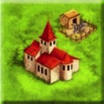

In [19]:
#View tree on each iteration - STEP 2 - Iterate

#By iteration
iterations = 700
def run_iteration(iterations):
    for it in range(iterations):
        mcts_agent.iteration()
run_iteration(iterations)
#cProfile.run("run_iteration(iterations)")

#By_choose_action
def run_choose_action():
    mcts_agent.max_iterations = iterations
    mcts_agent.choose_action(game_state)
#run_choose_action()

print("Iterations: ", mcts_agent.current_iterations)
print("FM calls: ", mcts_agent.current_fm)
print("Recommended action: ", mcts_agent.recommendation_policy())
print(mcts_agent.view_mcts_tree())
#print(mcts_agent.view_action_stats())
#print(mcts_agent.view_proven_tree())
Image("Games/Carcassonne/pygame_images/"+ str(game_state.next_tile_index)+".png")

In [20]:
np.mean(mcts_agent.root_node.leaf_node_depths())

3.6518375241779495

In [ ]:
#Create color palette

color_palette = [ "#B10909" #red
                ,  "#5B8C5A"#green
                ,"#56638A" #blue-purple
                , "#EC7316" #orange
                ,  "#FC738C" ] #pink
color_palette = ["#5B8C5A"
                ,"#56638A"
                , "#EC7316"]
color_palette[2] = eu.color_rgb_to_hex(eu.darken_color(eu.color_hex_to_rgb(color_palette[2]), 0.4))
color_palette[0] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[0]), 0.3))
color_palette[1] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[1]), 0.1))

eu.view_color_palette(color_palette)

print("color_palette = {}".format(color_palette))

In [ ]:
#MATCH

mcts_agent = mcts.MCTS_Player(max_iterations = 100)
siea_mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = 100)
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
game_state = carc.CarcassonneState()
#game_state = mnk.GameState(3,3,3)
game_state.set_initial_state()
gp1, gp2 = eu.play_match([mcts_agent, siea_mcts_agent], game_state, 2, os.path.join("Outputs", "test_match_carc"), random_seed = 1)

In [5]:
#Match with debugger.py

TotalGames = 10
logs = True
random_seed = 1
if random_seed is not None: 
    rd.seed(random_seed)
    np.random.seed(random_seed)
else: 
    random_seed = rd.randint(0, 2**32)
    print("meh")
    rd.seed(random_seed)
    np.random.seed(random_seed)

game_state = carc.CarcassonneState(initial_tile_quantities=[1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = mnk.GameState(m=3,n=3,k=3)
game_state.set_initial_state()
agent3 = arand.RandomPlayer()
agent2 = mcts.MCTS_Player(max_iterations=100)
players = [agent2, agent3]
games_count = 0
WinnerCount = {0:0, 1:0, "Draw":0}

all_action_logs = pd.DataFrame()
all_game_logs = pd.DataFrame()

ST = time.time()

for game in range(TotalGames):
    #gs = game_state.duplicate()
    gs = game_state.duplicate()

    #Set logs
    action_logs = pd.DataFrame()
    game_logs = pd.DataFrame()
    if logs:
        for p in players:
            p.logs = True

    #Play game
    safe_count = 0
    while not gs.is_terminal:
        start_time = time.time()
        action = players[gs.player_turn].choose_action(gs)
        #action = rd.choice(gs.available_actions)
        selection_time = time.time() - start_time

        #Update logs
        if logs:
            action_log = players[gs.player_turn].choose_action_logs #Assumes this log is single row
            action_log["game_index"] = games_count
            action_log["selection_time"] = selection_time
            action_log["returned_action"] = str(action)
            action_log["pg_player"] = str(players[gs.player_turn])
            action_logs = pd.concat([action_logs, action_log], ignore_index=True)
            game_logs = pd.concat([game_logs, gs.logs_data()], ignore_index=True)

        #safety check      
        safe_count += 1
        if safe_count > 1000: 
            print("Safe count exceeded")
            print(gs.logs_data())
            print("Last action:" + str(action))
            break
        assert safe_count < 1000, "Safe count exceeded"

        #Make action
        gs.make_action(action)

    if logs:
        #Final logs by action
        final_logs_by_action = pd.concat([action_logs, game_logs], axis=1)


        #Final logs by game
        final_logs_by_game_dict = {}
        for i, player in enumerate(players):
            final_logs_by_game_dict["Player_" + str(i)] = str(player)
        final_logs_by_game_dict["game_random_seed"] = random_seed
        final_logs_by_game_dict["game_index"] = games_count
        final_logs_by_game = pd.DataFrame(final_logs_by_game_dict, index=[0])
        final_logs_by_game = pd.concat([final_logs_by_game, gs.logs_data()], axis=1)
            
    games_count += 1
    if gs.winner is None:
        WinnerCount["Draw"] += 1
    else: WinnerCount[gs.winner] += 1
    print("Game", games_count, "ended, winner:", gs.winner, "scores:", gs.Scores)

    all_action_logs = pd.concat([all_action_logs, final_logs_by_action], ignore_index=True)
    all_game_logs = pd.concat([all_game_logs, final_logs_by_game], ignore_index=True)

ET = time.time()

all_action_logs.to_csv(os.path.join("Outputs","test_carc","by_action.csv"))
all_game_logs.to_csv(os.path.join("Outputs","test_carc","by_game.csv"))
print("Games ended, time:", str(ET - ST))
print("WinnerCount",WinnerCount)

In [2]:
#Evolved formulas analysis, now in experiment

logs_path = os.path.join("Outputs","FO_single_decision_new")
data = pd.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
evolved_formula_data = pd.DataFrame()
for agent in data["Player"].unique():
    if "EA" in agent:
        for f_index in data["Function_index"].unique():
            tdata = data[(data["Player"]==agent) & (data["Function_index"]==f_index)]
            fa_data = eu.evolved_formula_analysis(tdata)
            fa_data["Player"] = [agent]
            fa_data["Function_index"] = [f_index]
            evolved_formula_data = pd.concat([evolved_formula_data, fa_data])
evolved_formula_data.to_csv(os.path.join(logs_path, "evolved_formula_analysis.csv"), mode='a')

In [ ]:
dupe_state = game_state.duplicate()
dupe_state.make_action(rd.choice(dupe_state.available_actions))

In [8]:
for file_name in ["evolution_logs.csv"]:
    experiment_path = os.path.join("Outputs","FO_single_decision_new2")
    file_path_list = lm.find_log_files(file_name, experiment_path)
    lm.combine_logs(experiment_path, file_name, file_path_list)

In [ ]:
#Plot histograms

n_bins = 2**7
experiment_path = os.path.join("Outputs","FO_single_decision_new2")
file_path_list = lm.find_log_files("tree_data.csv", experiment_path)
print(["\n" + f for f in file_path_list])
for function_index in range(5):
  data_list = []
  subplot_titles = []
  file_paths = []

  #Add ea vanilla
  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
      agent_name = file_path.split(os.sep)[-2]
      if "_c" in agent_name:
        data_list.append(pd.read_csv(file_path)) #mod to get interesting runs
        if "1_4142" in agent_name:
           agent_name= agent_name.replace("1_4142", "\u221A\u03052\u0305")
        if "0_5" in agent_name:
           agent_name= agent_name.replace("0_5", "0.5")
        agent_name = agent_name.replace("MCTS_", "MCTS ")
        agent_name = agent_name.replace(" c", " c = ")
        subplot_titles += [agent_name]
        file_paths += [file_path]
        paths_to_remove += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "EA_" in agent_name and not "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))  #mod to get interesting runs
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
    
  if subplot_titles != [] and data_list != []:
    fop = fo.GameState(function_index=function_index)

    #print(len(data_list))
    """ #mod to get interesting runs
    interesting_runs = [0,10,16,36,41,45,72,73,97]
    interesting_data = []
    interesting_titles = ["Tunnel","Even","Random", "Exploratory", "Opposite", "Emergent 1", "Emergent 2", "Emergent 3", "UCB1 c=0.25"]
    interesting_titles = ["Behaviour type " + str(i) for i in range(len(interesting_runs))]
    for j in range(10):
      new_data_list = []
      subplot_titles = []
      dat = data_list[1]
      for i in range(j*10,(j+1)*10):
        tdat = dat.loc[dat["run"] == i]
        new_data_list = new_data_list + [tdat]
        if i==40:
          my_dat = tdat
        if i in interesting_runs:
          interesting_data += [tdat]
        subplot_titles += ["Run " + str(i)]
      subdata_list = new_data_list
    """

    plot = eu.fo_tree_histogram_average(data_list,  #mod to get interesting runs
                        fop.function, 
                        "F"+str(function_index+1) , #mod to get interesting runs
                        divisions = 3,
                        n_buckets = n_bins, 
                        subplot_titles = [""] + subplot_titles, #mod to get interesting runs
                        max_x_location=fop.max_location[0],
                        y_ref_value=None)
    #plot.write_image(os.path.join(experiment_path, "Interesting_runs.png"))#"F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'))#, width=800, height=1000) 
    plot.write_image(os.path.join(experiment_path, "F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'), width=800, height=1000) 
    plot.show()
    #0,5,

In [1]:
#LUDO

class LudoArrow():
    def __init__(self,  end_index=None, player_house=None):
        self.player_house = player_house #The player whose house this is
        self.end_index = end_index

class LudoSquare():
    def __init__(self, index, is_safe=False, arrow=None, content=None, next_square_index=None, player_house=None, is_victory_path=False):
        self.index = index
        self.is_safe = is_safe
        self.content = content #A list of pieces
        self.next_square_index = next_square_index #The index of the next square
        self.player_house = player_house #The player whose house this sends to
        self.is_victory_path = is_victory_path #Whether this is a victory path square

class LudoPiece():
    def __init__(self, index, player):
        self.index = index
        self.player = player
        
class GameState():
    def __init__(self, n_players, pieces_per_player=4):
        self.players = ["red", "green", "blue", "yellow"]
        self.n_players = n_players
        self.pieces_per_player = pieces_per_player
    def set_initial_state(self):
        self.board = {}
        self.players_houses = {12:"red", 25:"green", 38:"blue", 51:"yellow"}
        self.players_starting_index = {"red":15, "green":28, "blue":41, "yellow":2}
        for i in range(52):
            if i in [2, 10, 15, 23, 28, 36, 41, 49]: #safe squares
                square = LudoSquare(i, is_safe=True)
            elif i in [6, 19, 32, 45]: #squares with immediate arrows
                arrow = LudoArrow(end_index=i+1)
                square = LudoSquare(i, arrow=arrow)
            elif i in [10, 23, 36, 49]: #squares with arrows to the player houses
                arrow = LudoArrow(end_index=53, player_house=i)
                square = LudoSquare(i, arrow=arrow)
            elif i in [13, 26, 39, 52]:
                square = LudoSquare(i, player_house=self.players_houses[i])







In [ ]:
#LORCANA API
import requests
import json
import pandas as pd

names_request = requests.get('https://api.lorcana-api.com/lists/names')
if names_request.status_code == 200:
    response_string = str(names_request.content).split("\\n")
print("Got ", str(len(response_string)), " names from the API")

names = []
card_dataset = []
failed_cards = []
for raw_name in response_string:
    card_data = None
    attempts = 0
    while attempts < 5:
        if "," in raw_name: #Filtering for missing cards
            name = raw_name.replace("\"", "")
            name = name.replace("\\", "")
            name = name.replace(" ", "")
            name = name.replace(",", "")

            full_string = 'https://api.lorcana-api.com/strict/' + name
            print("Trying string: ", full_string)
            #print(full_string)
            card_data = requests.get(full_string)
            if card_data.status_code == 200:
                print(card_data.content)
                break
            else:
                print('Request failed with status code:', card_data.status_code)
                card_data = None
                attempts += 1
        else:
            print("Skipping: ", raw_name)
            break
        
    #Save the data in a dictionary
    if card_data is not None:
        card_dict = json.loads(card_data.content)
        card_dataset.append(card_dict)
    else:
        failed_cards.append(raw_name)
        print("Failed to get data for: ", raw_name)
    
#Merge all the dicionaries in a single dataframe
df = pd.DataFrame()
for card_dict in card_dataset:
    #card_df = pd.DataFrame(card_dict, index = [0])
    card_df = pd.DataFrame()
    for key,value in card_dict.items():
        print(key, value)
        card_df[key] = [value]
    df = pd.concat([df, card_df], axis = 0)
    #Save df to csv
    df.to_csv("card_data.csv", index = False)